# CallMeMaybe Operator Inefficiency Analysis

## Operator Segmentation via Clustering – Telecom Inefficiency Analysis

## Project Context

**CallMeMaybe**, a virtual telephony service, seeks to identify **inefficient operators** within its system. An operator is considered **inefficient** when they show:

- A high number of **missed incoming calls** (internal or external)  
- Long **average wait times** for incoming calls  
- (Optionally) A low volume of **outgoing calls**

This notebook focuses on using **unsupervised machine learning** to group operators based on performance and behavioral patterns, with the goal of **identifying inefficient clusters**.

---

## Objectives

1. Engineer relevant performance metrics for each operator:
   - Missed incoming call rate  
   - Average wait time  
   - Outgoing call volume  
2. Standardize and prepare features for modeling  
3. Apply **K-Means clustering** to segment operators into groups with similar behavior  
4. Visualize and analyze clusters to identify patterns of inefficiency  
5. Validate findings using statistical insights and compare performance across clusters

---

## Data Sources

- `telecom_dataset_us.csv`: Contains call logs, operator IDs, call directions, durations, and flags for missed calls  
- `telecom_clients_us.csv`: Contains client metadata such as tariff plan and registration date  

---

## Outcome

By clustering operators based on their call handling behavior, we aim to **highlight groups with poor performance** and provide **data-driven support for operational decisions** such as coaching, monitoring, or reassignment.

**Specify details** <br>
Definition of “ineffectiveness”: <br>
<ul>
What specific thresholds for dropped calls and hold time are considered “high volume”? <br>
How do we weight inbound vs. internal vs. outbound calls? <br>
What time window do we evaluate (daily, weekly, monthly)? <br>
</ul>
Scope of data:
<ul>
Do we exclude operators with fewer than X total calls? <br>
Do we only consider active accounts within a minimum period? <br>
</ul>

**Tableau Dashboard**

https://public.tableau.com/views/Book1_17484530567970/Dashboard1?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

## 1. Initial Data Loading and Exploration

Import libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import dendrogram, linkage


Read Datasets

In [2]:
df = pd.read_csv('../datasets/telecom_dataset_us.csv')
df_clients = pd.read_csv('../datasets/telecom_clients_us.csv')

In [3]:
print(df.shape)
print(df.info())
display(df.head())

(53902, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
print(df_clients.shape)
print(df_clients.info())
display(df_clients.head())

(732, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


## 2. Data Cleaning and Preparation

Check for null and duplicate data <br>
Impute, delete, or retain.

In [5]:
print(df.isnull().sum())
print(df.duplicated().sum())

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
4900


There are several missing values in operator_id and a few in internal. <br>
There are 4,900 duplicates.

In [6]:
#delete duplicates
df = df.drop_duplicates()
#fill missing values
df['operator_id'] = df['operator_id'].fillna(-1)
#assume missing is external calls
df['internal'] = df['internal'].fillna(False)
#check
print(df.isnull().sum())
print(df.duplicated().sum())

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64
0


/var/folders/j_/7ll1w8n13nq1q1p7bf8pyjj00000gn/T/ipykernel_56580/341211105.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['internal'] = df['internal'].fillna(False)


In [7]:
#verify null values in df_clients
print(df_clients.isnull().sum())
print(df_clients.duplicated().sum())

user_id        0
tariff_plan    0
date_start     0
dtype: int64
0


Data conversion

In [8]:
#convertr float to int
df['operator_id'] = df['operator_id'].astype(int)
#convert date to to_datetime
df['date']= pd.to_datetime(df['date'])
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

In [9]:
#extract date because we don't need time
df['date'] = df['date'].dt.date
display(df)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,-1,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10,out,True,957922,False,1,0,25
53897,168606,2019-11-10,out,True,957922,True,1,0,38
53898,168606,2019-11-11,out,True,957922,False,2,479,501
53899,168606,2019-11-15,out,True,957922,False,4,3130,3190


In [10]:
#add columns
df['wait_time'] = df['total_call_duration'] - df['call_duration']

In [11]:
#merge dataframes to have plan information
df_plan = pd.merge(df,
                df_clients,
                on='user_id',
                how='left')
df_plan

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time,tariff_plan,date_start
0,166377,2019-08-04,in,False,-1,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...
48997,168606,2019-11-10,out,True,957922,False,1,0,25,25,C,2019-10-31
48998,168606,2019-11-10,out,True,957922,True,1,0,38,38,C,2019-10-31
48999,168606,2019-11-11,out,True,957922,False,2,479,501,22,C,2019-10-31
49000,168606,2019-11-15,out,True,957922,False,4,3130,3190,60,C,2019-10-31


## 3. Exploratory Data Analysis (EDA)

In [12]:
df.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,wait_time
count,49002.000000,49002.000000,49002.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,777067.674911,16.462777,866.282091,1156.558202,290.276111
std,598.558965,329774.097101,63.604098,3775.503352,4451.473661,1132.155291
min,166377.000000,-1.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,890416.000000,1.000000,0.000000,46.000000,17.000000
50%,167158.000000,906406.000000,4.000000,37.000000,208.000000,55.000000
75%,167819.000000,929884.000000,12.000000,570.000000,901.000000,200.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,46474.000000


In [13]:
# flags for call type
df['in_call']   = np.where(df['direction']=='in', df['calls_count'], 0)
df['out_call']  = np.where(df['direction']=='out', df['calls_count'], 0)
df['missed_in'] = np.where(
    (df['direction'] == 'in') & (df['is_missed_call']),
    1, 0
)

# incoming call duration 
df['in_total_duration'] = np.where(
    df['direction'] == 'in',
    df['total_call_duration'],
    0
)
df['in_calls_count'] = np.where(
    df['direction'] == 'in',
    df['calls_count'],
    0
)

# wait time calculation
df['wait_time'] = np.where(
    df['direction'] == 'in',
    df['total_call_duration'] - df['call_duration'],
    0
)
# discard erroneous values
df = df[df['wait_time'] >= 0]

# filter valid operators
df_ops = df[df['operator_id'] != -1]

# group and calculate metrics
operator_stats = (
    df_ops
    .groupby('operator_id')
    .agg(
        total_calls        = ('calls_count',       'sum'),
        total_in_calls     = ('in_call',           'sum'),
        total_out_calls    = ('out_call',          'sum'),
        missed_in_calls    = ('missed_in',         'sum'),
        total_in_duration  = ('in_total_duration', 'sum'),
        total_wait_time    = ('wait_time',         'sum')
    )
)

# derived metrics
# average incoming call duration
operator_stats['avg_in_duration'] = (
    operator_stats['total_in_duration'] / operator_stats['total_in_calls']
).replace([np.inf, np.nan], 0)

# missed incoming call rate
operator_stats['missed_in_rate'] = (
    operator_stats['missed_in_calls'] / operator_stats['total_in_calls']
).fillna(0)

# average wait time for incoming calls
operator_stats['avg_wait_time'] = (
    operator_stats['total_wait_time'] / operator_stats['total_in_calls']
).replace([np.inf, np.nan], 0)

display(operator_stats)

,total_calls,total_in_calls,total_out_calls,missed_in_calls,total_in_duration,total_wait_time,avg_in_duration,missed_in_rate,avg_wait_time
operator_id,,,,,,,,,
879896,930,58,872,0,6190,574,106.724138,0.0,9.896552
879898,7313,104,7209,0,8033,1680,77.240385,0.0,16.153846
880020,45,7,38,0,353,54,50.428571,0.0,7.714286
880022,197,8,189,0,624,112,78.000000,0.0,14.000000
880026,2232,24,2208,0,1730,143,72.083333,0.0,5.958333
...,...,...,...,...,...,...,...,...,...
972410,77,0,77,0,0,0,0.000000,0.0,0.000000
972412,61,1,60,0,145,25,145.000000,0.0,25.000000
972460,51,1,50,0,18,4,18.000000,0.0,4.000000


Distribución del número total de llamadas.

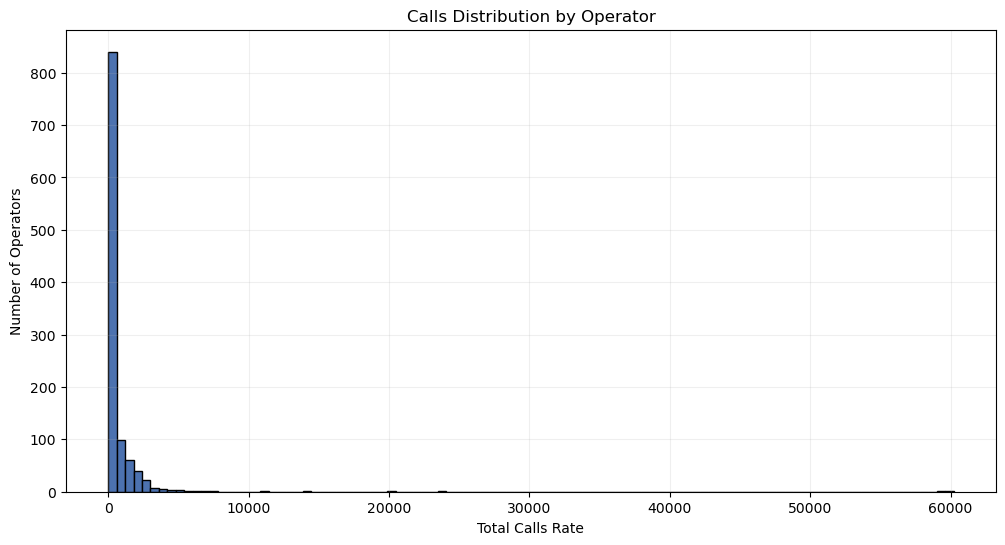

In [14]:
operator_stats['total_calls'].plot(kind='hist',
                           figsize=(12,6),
                           bins=100,
                           title='Calls Distribution by Operator',
                           color= '#4C72B0',
                            edgecolor='black'
                          )

plt.xlabel('Total Calls Rate')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

In [15]:
# percentiles calculation
q10 = operator_stats['total_calls'].quantile(0.10)
q25 = operator_stats['total_calls'].quantile(0.25)
print(f"p10 = {q10:.0f}, p25 = {q25:.0f}")

p10 = 3, p25 = 10


The percetil10 = 3 calls is used to filter the data frame:
<ul>
– With fewer than 4 calls, the missed call rate is very unstable, with a huge margin of error. <br>
– By cutting at p10 = 3, you are left with the 90% of operators who have a minimum volume that guarantees a more reliable result.
</ul>

In [16]:
#filter operators with more than 3 calls (percetil10)
operator_stats = operator_stats[operator_stats['total_calls'] > 3 ]

Distribution of the rate of missed incoming calls

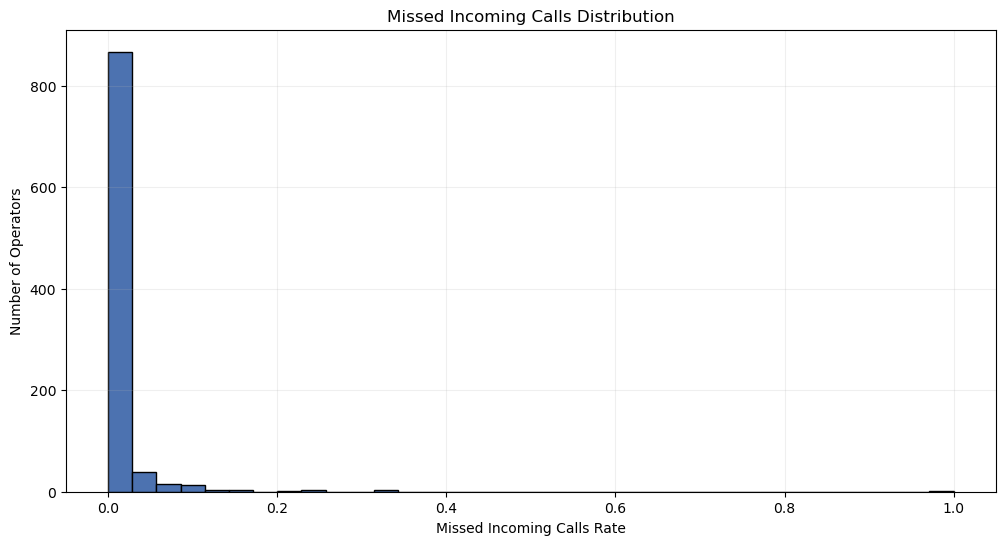

In [17]:
operator_stats['missed_in_rate'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Missed Incoming Calls Distribution',
                           color= '#4C72B0',
                           edgecolor='black'
                          )
plt.xlabel('Missed Incoming Calls Rate')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

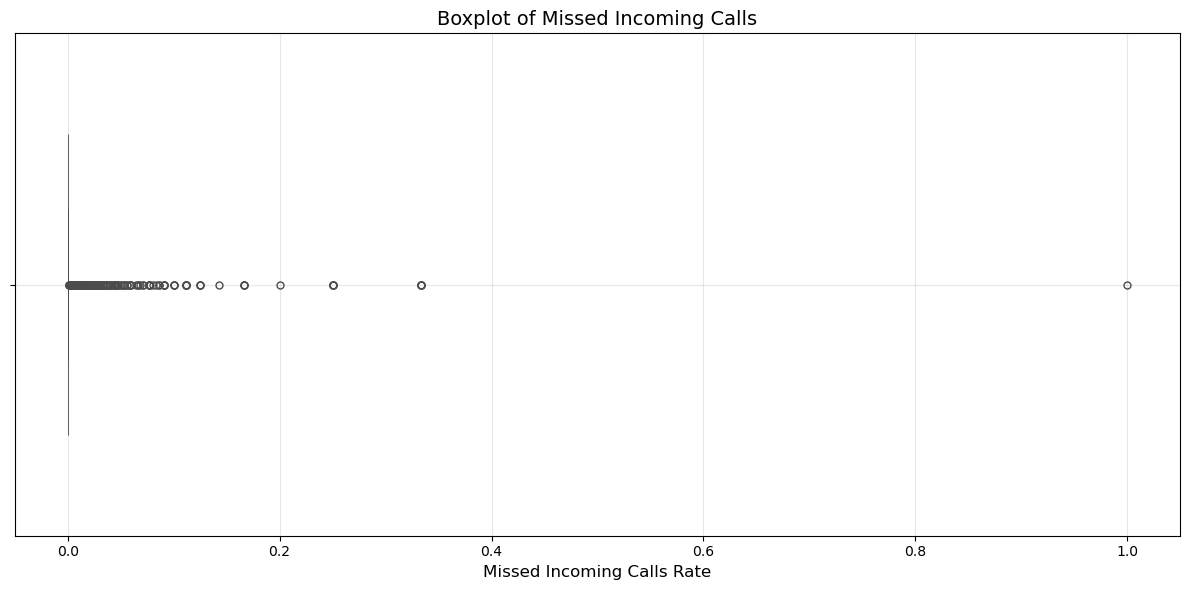

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['missed_in_rate'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=0.5,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Missed Incoming Calls Rate', fontsize=12)
plt.title('Boxplot of Missed Incoming Calls', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

Most operators are close to 0, which means they have almost no missed calls and for the other side we have one operator with 1 missed incoming calls rate, that means that this operator lost all the calls

Out calls distribution

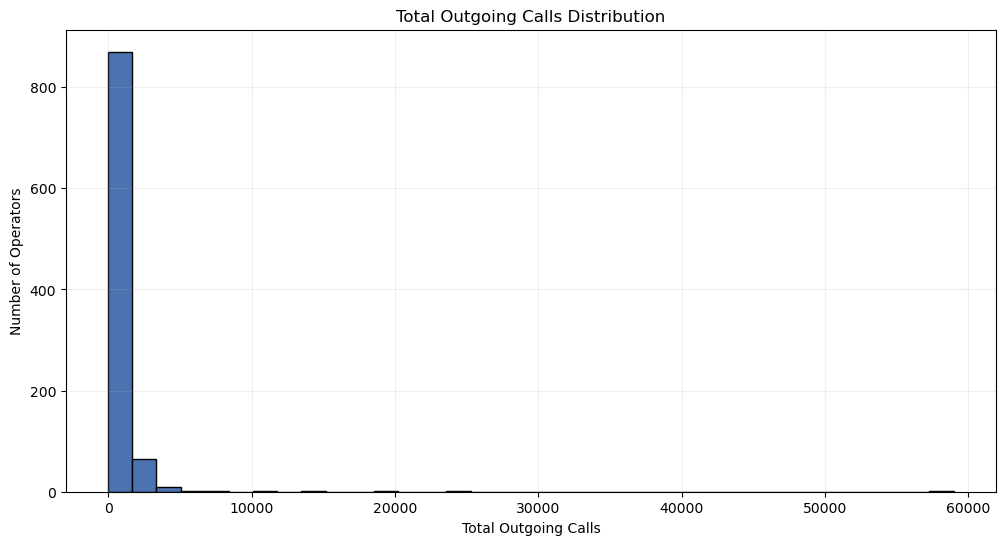

In [19]:
# Histogram
operator_stats['total_out_calls'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Total Outgoing Calls Distribution',
                           color= '#4C72B0',
                            edgecolor='black'
                          )
plt.xlabel('Total Outgoing Calls')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

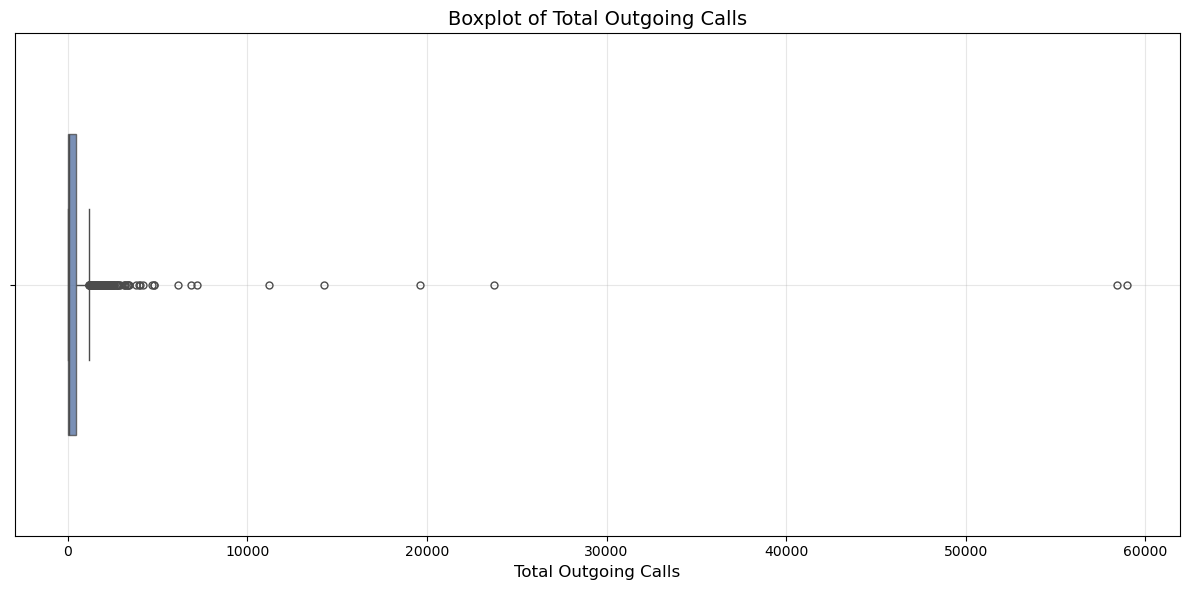

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['total_out_calls'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=1,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Total Outgoing Calls', fontsize=12)
plt.title('Boxplot of Total Outgoing Calls', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

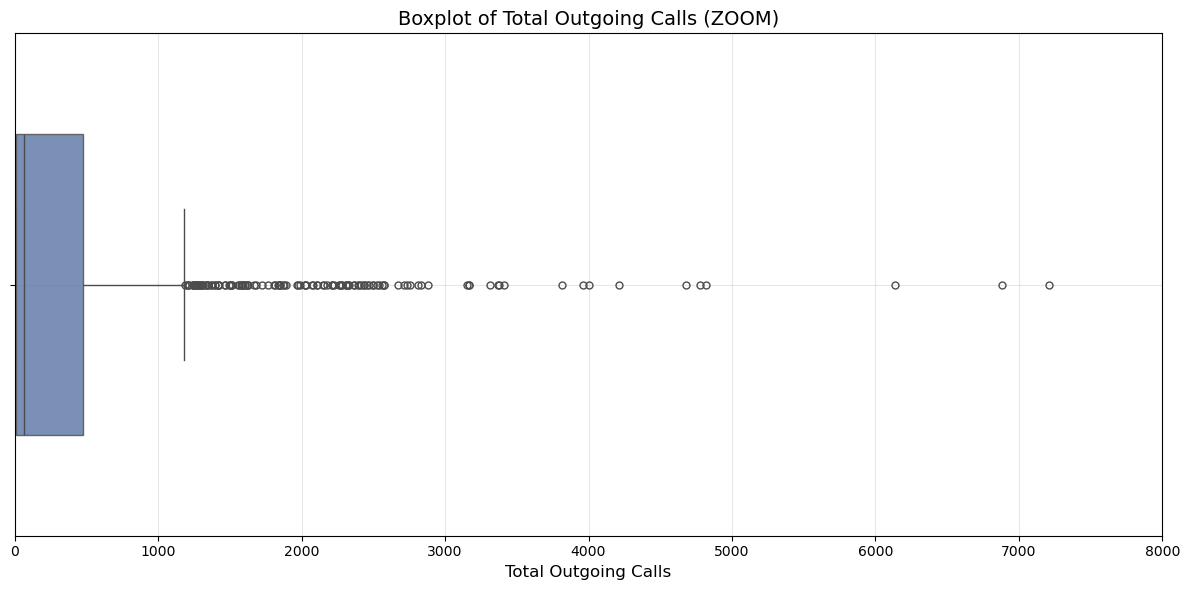

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['total_out_calls'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=1,                  
    boxprops=dict(alpha=0.8),    
)
plt.xlim(0,8000)
plt.xlabel('Total Outgoing Calls', fontsize=12)
plt.title('Boxplot of Total Outgoing Calls (ZOOM)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

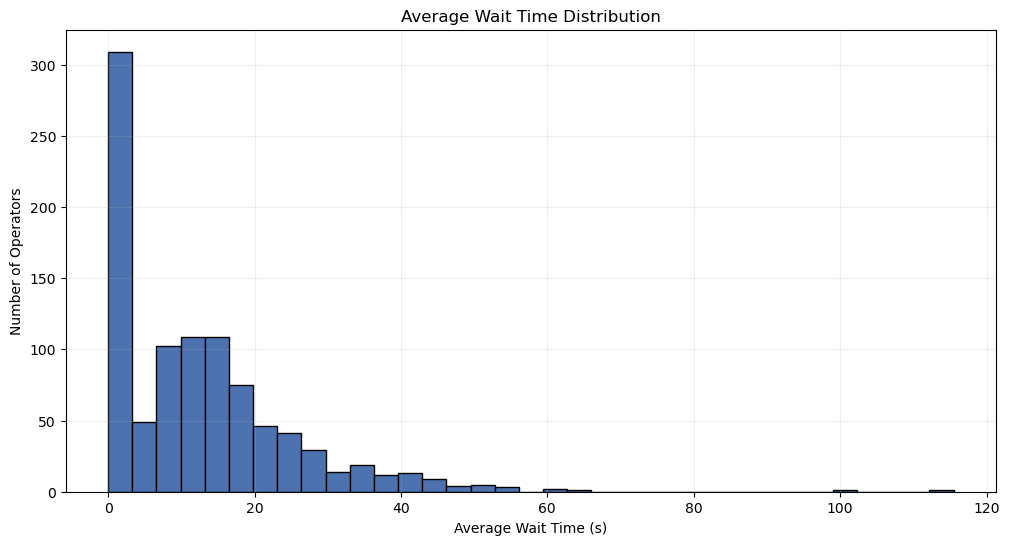

In [22]:
# Histogram of average wait time
operator_stats['avg_wait_time'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Average Wait Time Distribution',
                           color= '#4C72B0',
                            edgecolor='black'
                          )
plt.xlabel('Average Wait Time (s)')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

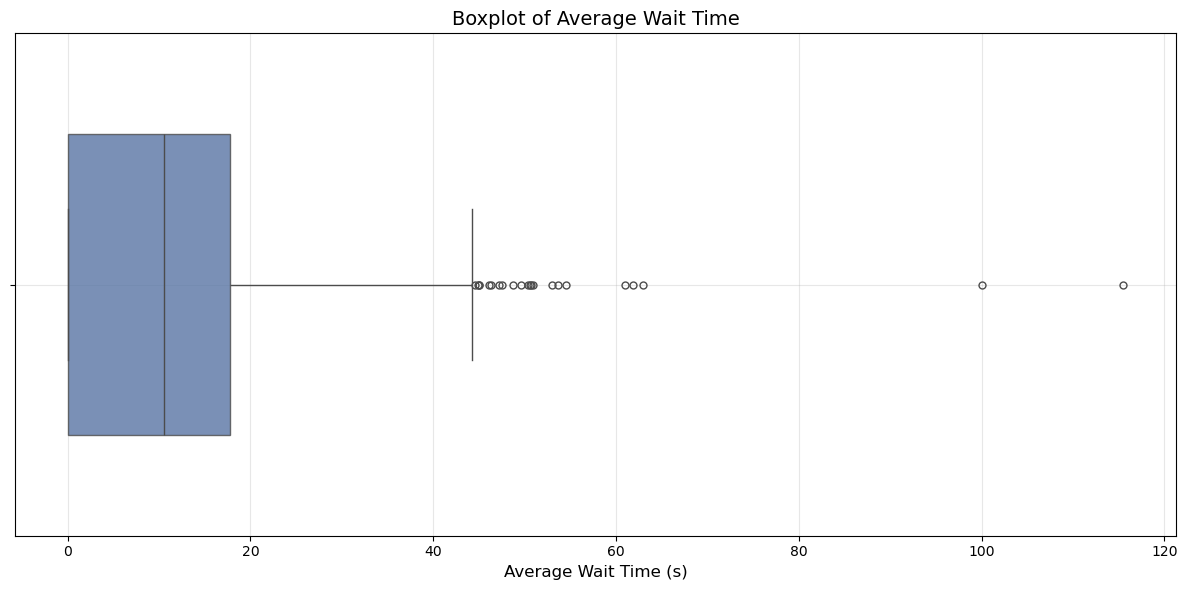

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['avg_wait_time'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=1,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Average Wait Time (s)', fontsize=12)
plt.title('Boxplot of Average Wait Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

Distribution of average call duration

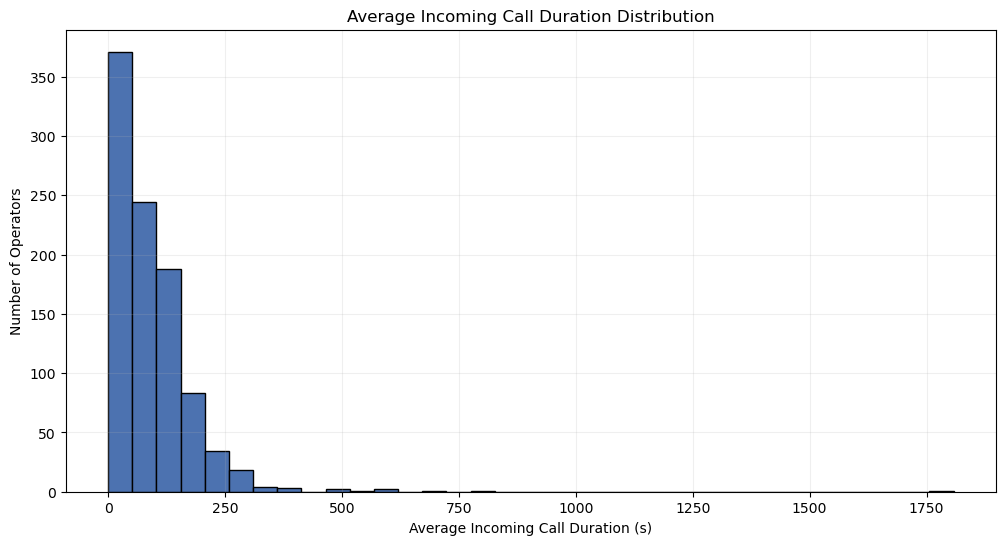

In [24]:
operator_stats['avg_in_duration'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Average Incoming Call Duration Distribution',
                           color= '#4C72B0',
                           edgecolor='black'
                          )
plt.xlabel('Average Incoming Call Duration (s)')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

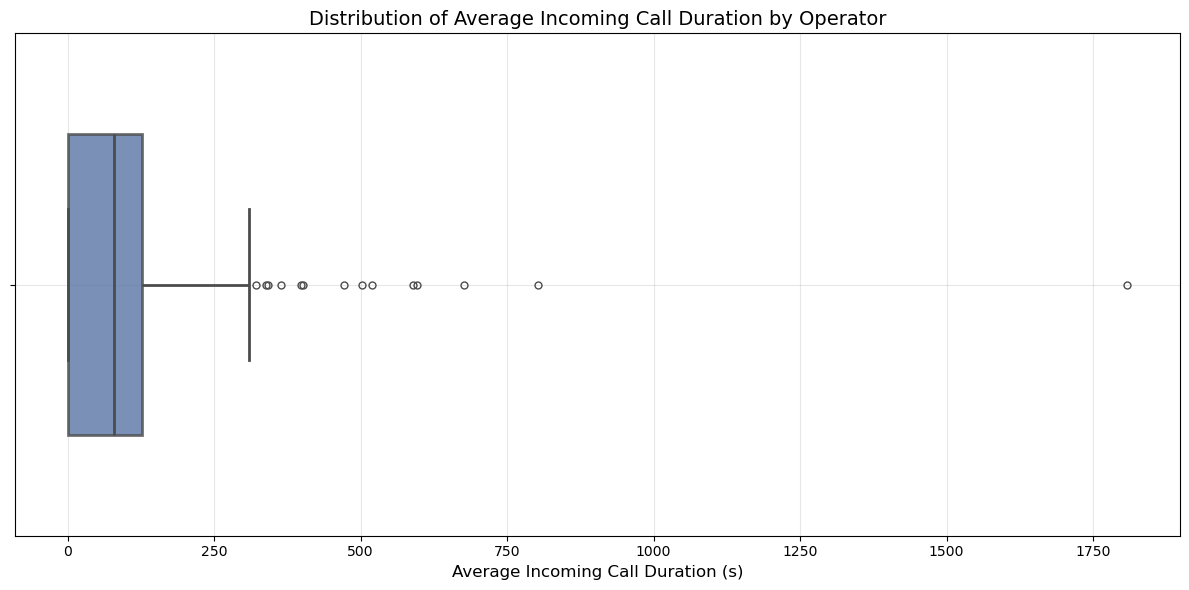

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['avg_in_duration'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=2,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Average Incoming Call Duration (s)', fontsize=12)
plt.title('Distribution of Average Incoming Call Duration by Operator', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

Most call durations range between 100 and 400 seconds; however, there are also calls that exceed 500 seconds.

Relationship between missed call rate and average call duration

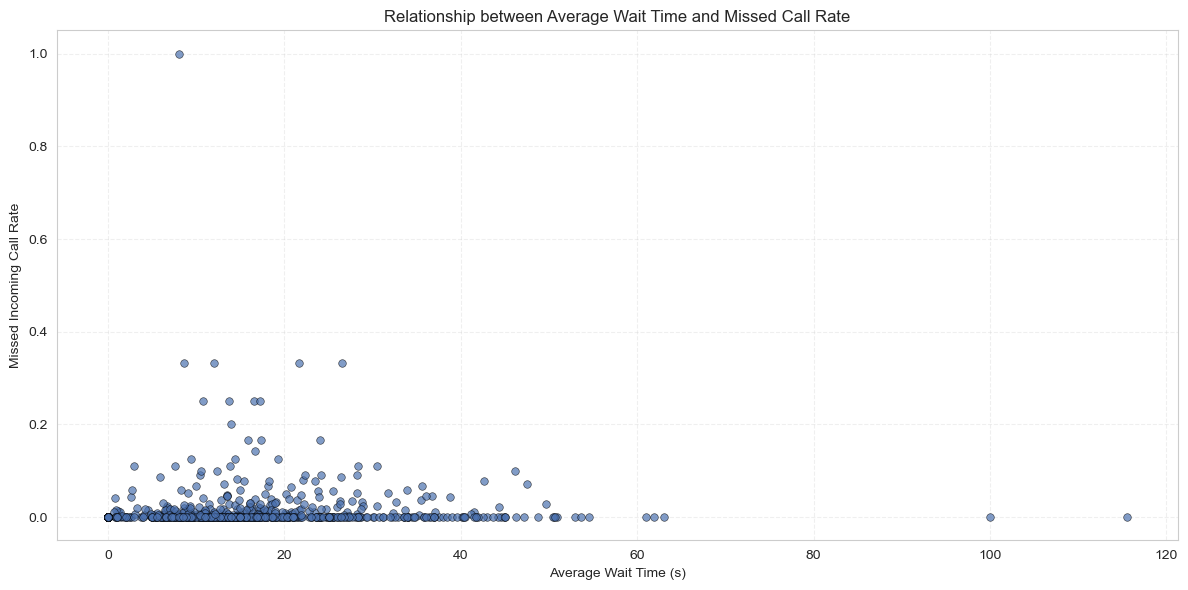

In [26]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='avg_wait_time',
    y='missed_in_rate',
    data=operator_stats,
    color='#4C72B0',
    s=30,                   
    alpha=0.7,              
    edgecolor='black'      
)



# Personalización
plt.xlabel('Average Wait Time (s)',fontsize=10)
plt.ylabel('Missed Incoming Call Rate', fontsize=10)
plt.title('Relationship between Average Wait Time and Missed Call Rate')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

<ul>
If the average wait time is high, customers may hang up before being served, increasing the dropped call rate.<br>
If an operator has both high values, it's probably inefficient or overloaded.<BR>
We don't see as many operators with both high dropped call rates and high wait times, although we do see them separately.
</ul>


## 4. Identifying Ineffective Operators Using K-Means Clustering

Correlation Map

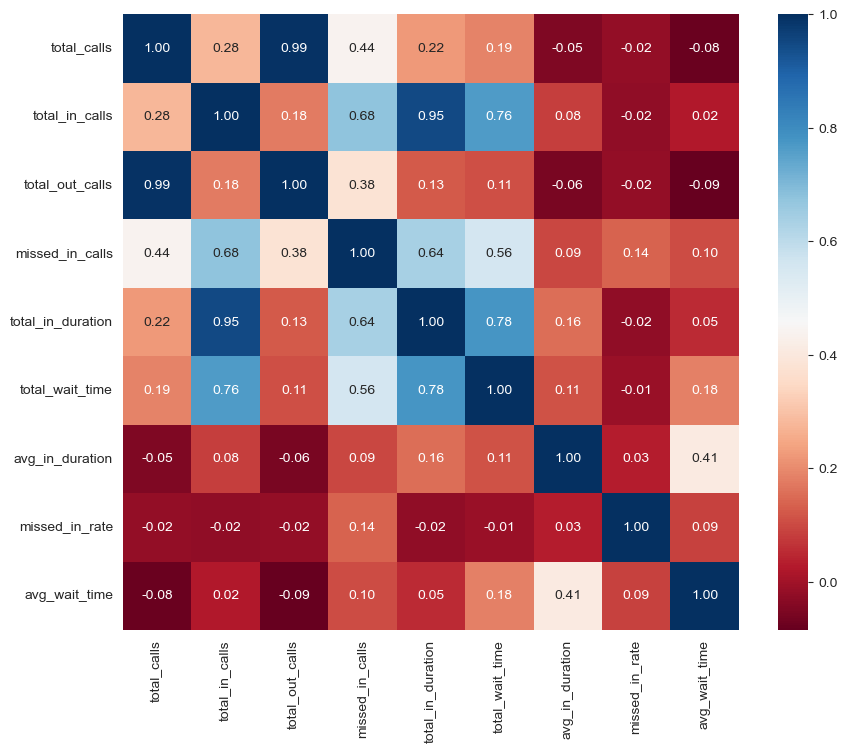

In [27]:
#correlation map
cm = operator_stats.corr()
plt.figure(figsize=(10, 8))
# create heatmap
sns.heatmap(cm, annot = True, fmt='.2f', square=True, cmap='RdBu')
plt.show()

Cluster Creation

In [28]:
# standardize the features
features = operator_stats[['total_calls', 'total_in_calls', 'total_out_calls',
                           'missed_in_calls', 'total_in_duration', 'total_wait_time',
                           'avg_in_duration', 'missed_in_rate', 'avg_wait_time']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

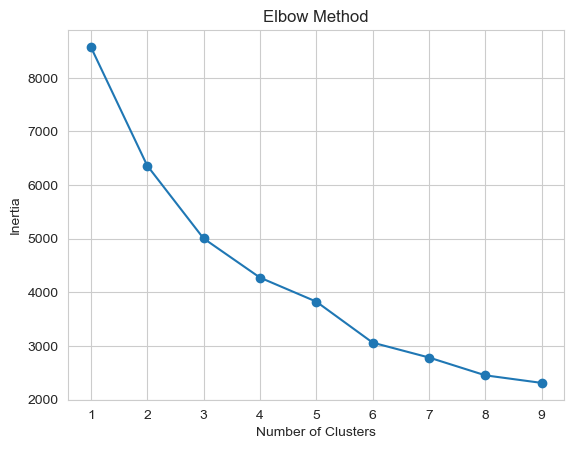

In [29]:
inertia = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

We chose 4 for the number of clusters

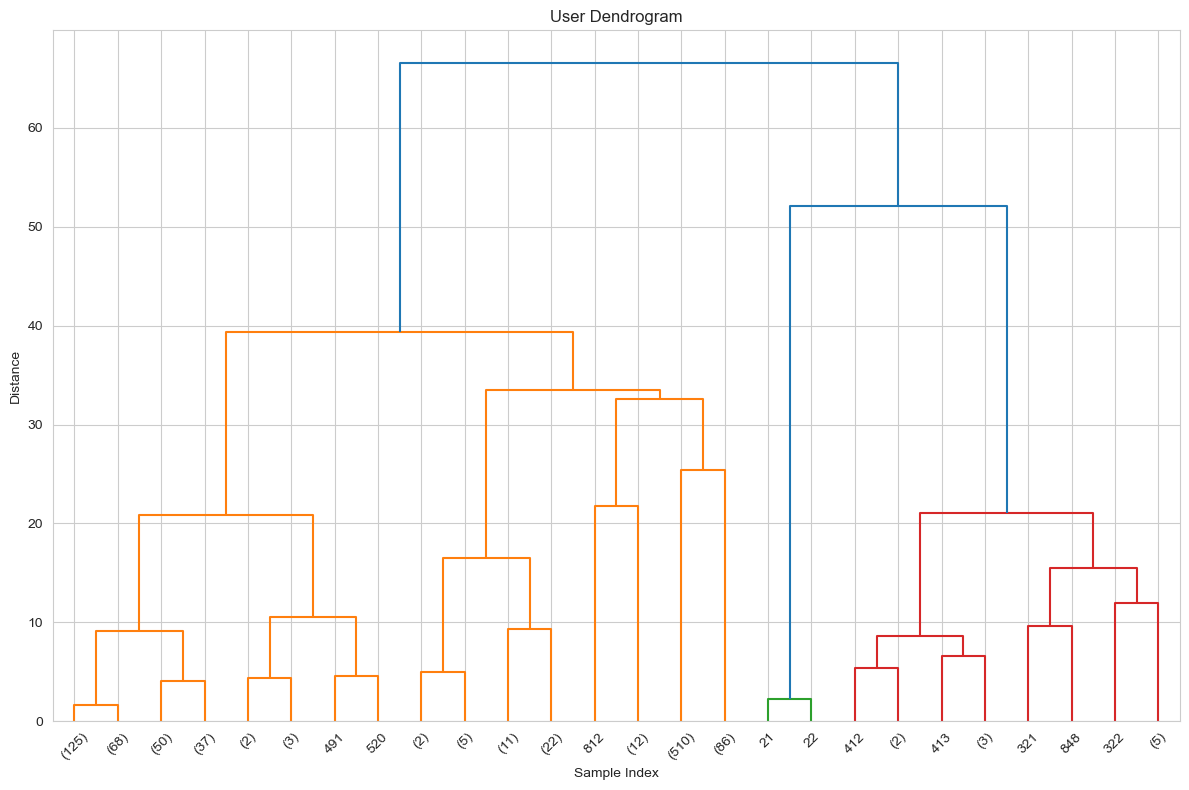

In [30]:
# calculate the linkage matrix
Z = linkage(X_scaled, method='ward')

# dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    truncate_mode='level', 
    p=4
                                     # number of levels to show
)
plt.title('User Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [31]:
#we used the elbow method to determine the optimal number of clusters = 3
kmeans = KMeans(n_clusters=4, random_state=42)
operator_stats['cluster'] = kmeans.fit_predict(X_scaled)

print(operator_stats['cluster'].value_counts().sort_index())


cluster
0    858
1     15
2      2
3     78
Name: count, dtype: int64


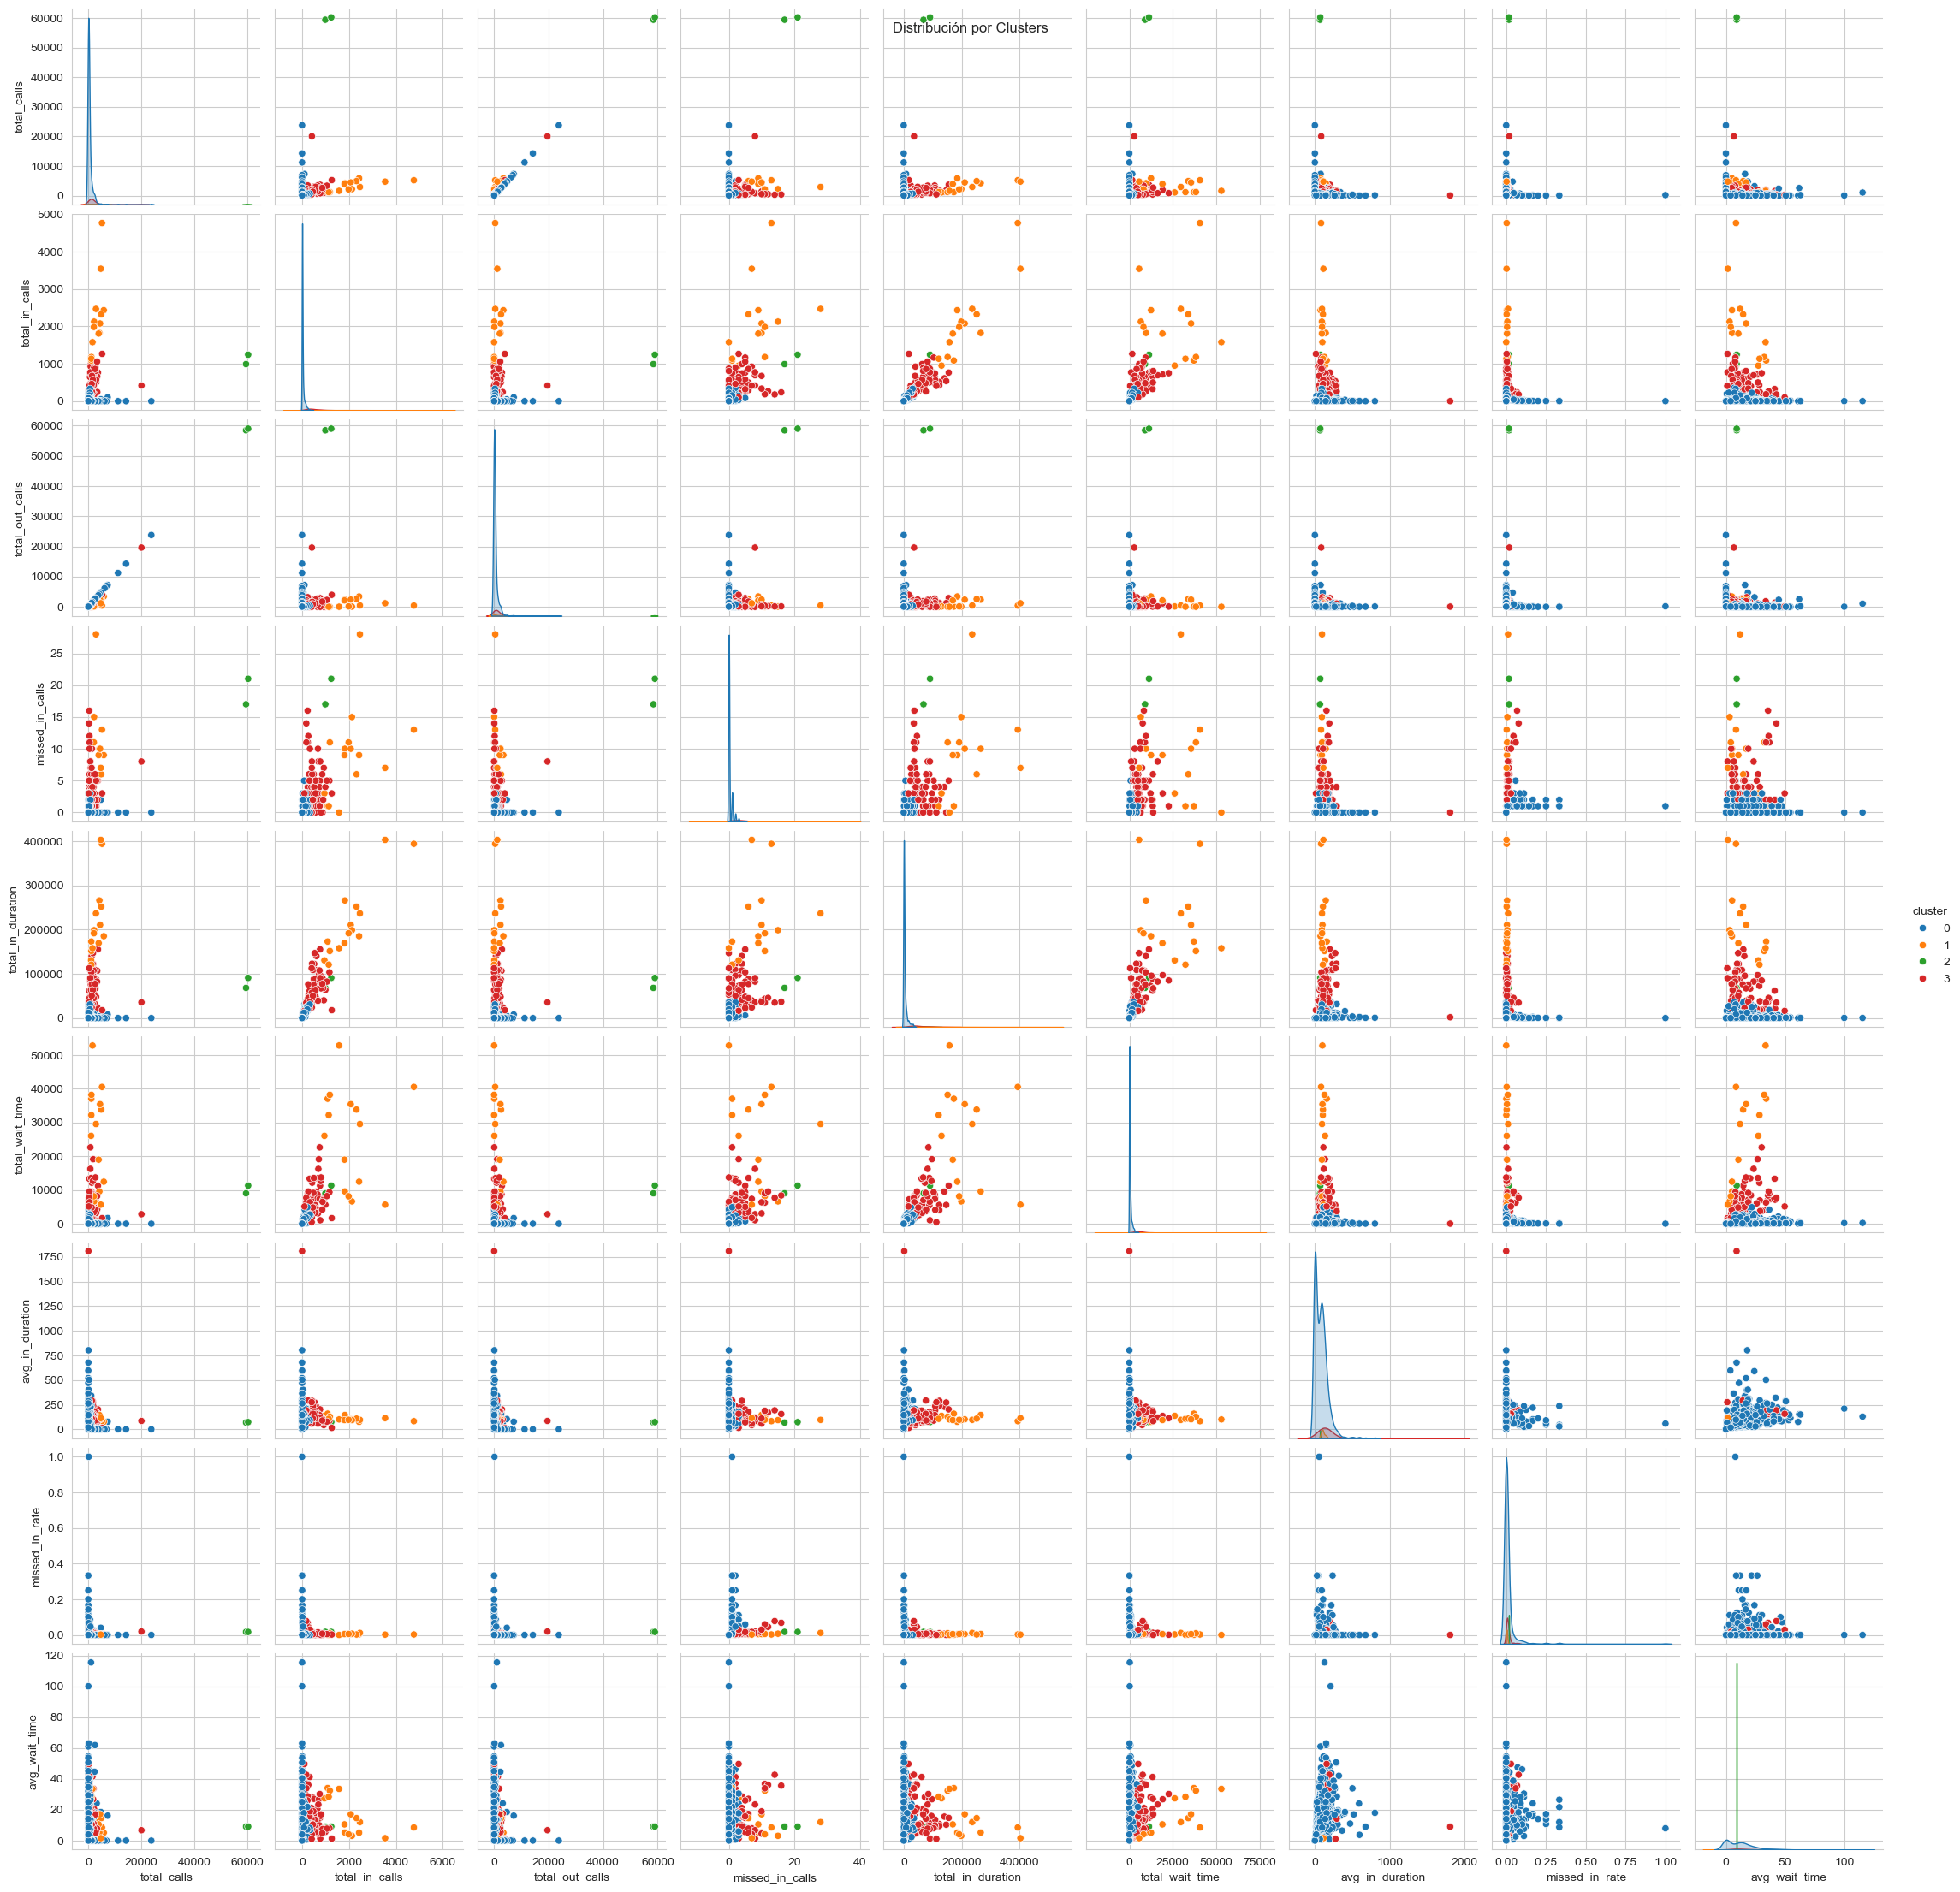

In [32]:
#visualization of clusters
sns.pairplot(operator_stats, hue='cluster', palette='tab10', diag_kind='kde')
plt.suptitle('Distribución por Clusters')
plt.show()

In [33]:
operator_stats.groupby('cluster').mean()[['missed_in_calls', 'missed_in_rate', 'avg_wait_time']]


,missed_in_calls,missed_in_rate,avg_wait_time
cluster,,,
0,0.244755,0.010779,11.769253
1,8.933333,0.004297,15.831157
2,19.000000,0.017009,9.089071
3,3.871795,0.011859,16.773641


- **Cluster 0** ✅  
  - Very low number of missed calls  
  - Moderate wait time  
  - **Most efficient**

- **Cluster 1** ⚠️  
  - Moderate number of missed calls  
  - Lowest missed call rate  
  - High average wait time  
  - **Possibly inefficient due to long wait times**

- **Cluster 2** 🚨  
  - **Highest** missed calls and **highest** missed call rate  
  - Low wait time  
  - **Least efficient** – many calls are not answered

- **Cluster 3** ⚠️  
  - Moderate missed calls and missed rate  
  - **Highest** average wait time  
  - **Potential inefficiency** due to delays in answering

We choose the Cluster 1,2,3 as inefficients operators and will see if they pass the statics tests


## 5. Statistical Hypothesis Testing

To formulate hypothesis tests, we will follow this approach:
<ul>
<li>Null hypothesis (H0): There is no significant difference between the groups </li>
<li>Alternative hypothesis (H1): There is a significant difference </li>
<li>Significance level: α = 0.05 </li>
</ul>

For **avg_wait_time** (Average Wait Time) <br>
H0: μ_avg_wait_time_inefficient = μ_avg_wait_time_efficient <br>
H1: μ_avg_wait_time_inefficient ≠ μ_avg_wait_time_efficient <br>

For **missed_in_rate** (Missed Call Rate) <br>
H0: μ_missed_in_rate_inefficient = μ_missed_in_rate_efficient <br>
H1: μ_missed_in_rate_inefficient ≠ μ_missed_in_rate_efficient <br>

For **total_out_calls** (Total Outgoing Calls) <br>
H0: μ_total_out_calls_inefficient = μ_total_out_efficient_calls <br>
H1: μ_total_out_inefficient_calls ≠ μ_total_out_efficient_calls <br>

Divide data in efficients and inefficients operatros

In [ ]:
inefficient_clusters = [1, 2, 3]
inefficient = operator_stats[operator_stats['cluster'].isin(inefficient_clusters)]
efficient = operator_stats[operator_stats['cluster'] == 0]

In [47]:
#Prueba para avg_wait_time
t_stat_wait, p_value_wait = stats.ttest_ind(
    inefficient['avg_wait_time'],
    efficient['avg_wait_time'],
    equal_var=False,  # Corrección de Welch
    nan_policy='omit'
)

#Prueba para missed_in_rate
u_stat, p_value = mannwhitneyu(
    inefficient['missed_in_rate'],
    efficient['missed_in_rate'],
    alternative='two-sided'
)

# Prueba para total_out_calls
t_stat_out, p_value_out = stats.ttest_ind(
    inefficient['total_out_calls'],
    efficient['total_out_calls'],
    equal_var=False,
    nan_policy='omit'
)

alpha = 0.05

print("Results for avg_wait_time:")
print(f"t-statistic = {t_stat_wait:.4f}, p-value = {p_value_wait:.23f}")
print(f"Conclusion: {'Reject H0. Inefficient carriers have SIGNIFICANTLY higher wait times' if p_value_wait < alpha else 'Do not reject H0'}")

print("\nResults for missed_in_rate:")
print(f"u-statistic = {u_stat:.4f}, p-value = {p_value:.10f}")

print(f"Conclusion: {'Reject H0. Inefficient carriers have SIGNIFICANTLY higher missed call rates' if p_value < alpha else 'Do not reject H0'}")

print("\nResults for total_out_calls:")
print(f"t-statistic = {t_stat_out:.4f}, p-value = {p_value_out:.10f}")
print(f"Conclusion: {'Reject H0. Inefficient carriers make SIGNIFICANTLY fewer outbound calls' if p_value_out < alpha else 'Do not reject H0'}")

Results for avg_wait_time:
t-statistic = 3.5930, p-value = 0.00051135402274004150905
Conclusion: Reject H0. Inefficient carriers have SIGNIFICANTLY higher wait times

Results for missed_in_rate:
u-statistic = 55885.0000, p-value = 0.0000000000
Conclusion: Reject H0. Inefficient carriers have SIGNIFICANTLY higher missed call rates

Results for total_out_calls:
t-statistic = 2.0384, p-value = 0.0448451163
Conclusion: Reject H0. Inefficient carriers make SIGNIFICANTLY fewer outbound calls


**Statistical Note:**  
The `missed_in_rate` variable was tested using the **Mann-Whitney U test** instead of a t-test due to:
- **Non-normal distribution** of the data
- **Strong imbalance** in sample sizes between groups
- Presence of **extreme values and small groups** (e.g., cluster 2 with only 2 observations)

This non-parametric test is more robust under these conditions and does not assume equal variances or normality.

## 7. Conclusions

In this project, we applied the **K-Means clustering algorithm**, using the **elbow method** to determine the optimal number of clusters (**k = 4**). Based on the analysis of key performance metrics, **Cluster 0** was identified as the **most efficient group**, while **Clusters 1, 2, and 3** were classified as **inefficient**.

To validate these findings, we performed statistical tests (t-tests and Mann-Whitney U) comparing efficient and inefficient groups. Results confirmed that inefficient operators tend to have **significantly higher wait times** and **fewer outbound calls**, supporting the clustering-based classification.